In [1]:
import sys
sys.path.append('.')

# Initialize Model

In [2]:
import torch
from diffusers import StableDiffusionPipeline
from pipeline_conform import ConformPipeline

pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"

sd_pipeline = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path=pretrained_model_name_or_path,
    torch_dtype=torch.float16,
).to("cuda")

pipeline = ConformPipeline(
    vae=sd_pipeline.vae,
    text_encoder=sd_pipeline.text_encoder,
    tokenizer=sd_pipeline.tokenizer,
    unet=sd_pipeline.unet,
    scheduler=sd_pipeline.scheduler,
    safety_checker=sd_pipeline.safety_checker,
    feature_extractor=sd_pipeline.feature_extractor,
)


/home/grads/tunahansmeral/miniconda3/envs/conform/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/grads/tunahansmeral/Repos/CONFORM/pipeline_conform.py:12: FutureWarning: Importing `DiffusionPipeline` or `ImagePipelineOutput` from diffusers.pipeline_utils is deprecated. Please import from diffusers.pipelines.pipeline_utils instead.
  from diffusers.pipeline_utils import DiffusionPipeline
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


# Hyperparameter

In [3]:
num_inference_steps = 50 # Number of steps to run the model
guidance_scale = 7.5 # Guidance scale for diffusion
attn_res = (16, 16) # Resolution of the attention map to apple CONFORM
steps_to_save_attention_maps = list(range(num_inference_steps)) # Steps to save attention maps
max_iter_to_alter = 30 # Which steps to stop updating the latents
refinement_steps = 20 # Number of refinement steps
scale_factor = 20 # Scale factor for the optimization step
iterative_refinement_steps = [0, 10, 20] # Iterative refinement steps
do_smoothing = True # Apply smoothing to the attention maps
smoothing_sigma = 0.5 # Sigma for the smoothing kernel
smoothing_kernel_size = 3 # Kernel size for the smoothing kernel
temperature = 0.5 # Temperature for the contrastive loss
softmax_normalize = False # Normalize the attention maps
softmax_normalize_attention_maps = False # Normalize the attention maps
add_previous_attention_maps = True # Add previous attention maps to the loss calculation
previous_attention_map_anchor_step = None # Use a specific step as the previous attention map
loss_fn = "ntxent" # Loss function to use
seed = 4913 # Seed for the generation

# Prompt

In [4]:
prompt = "a green glasses and a yellow clock"

## Indices

In [5]:
ids = pipeline.tokenizer(prompt).input_ids
indices = {
    i: tok
    for tok, i in zip(pipeline.tokenizer.convert_ids_to_tokens(ids), range(len(ids)))
}
print(indices)

{0: '<|startoftext|>', 1: 'a</w>', 2: 'green</w>', 3: 'glasses</w>', 4: 'and</w>', 5: 'a</w>', 6: 'yellow</w>', 7: 'clock</w>', 8: '<|endoftext|>'}


## Token Groups

In [6]:
token_groups = [
    [2, 3], 
    [6, 7]
]

## CONFORM Output

In [7]:
images, attention_maps = pipeline(
    prompt=prompt,
    token_groups=token_groups,
    guidance_scale=guidance_scale,
    generator=torch.Generator("cuda").manual_seed(seed),
    num_inference_steps=num_inference_steps,
    max_iter_to_alter=max_iter_to_alter,
    attn_res=attn_res,
    scale_factor=scale_factor,
    iterative_refinement_steps=iterative_refinement_steps,
    steps_to_save_attention_maps=steps_to_save_attention_maps,
    do_smoothing=do_smoothing,
    smoothing_sigma=smoothing_sigma,
    smoothing_kernel_size=smoothing_kernel_size,
    temperature=temperature,
    refinement_steps=refinement_steps,
    softmax_normalize=softmax_normalize,
    softmax_normalize_attention_maps=softmax_normalize_attention_maps,
    add_previous_attention_maps=add_previous_attention_maps,
    previous_attention_map_anchor_step=previous_attention_map_anchor_step,
    loss_fn=loss_fn,
)

  0%|          | 0/50 [00:00<?, ?it/s]/home/grads/tunahansmeral/miniconda3/envs/conform/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 50/50 [00:08<00:00,  6.10it/s]


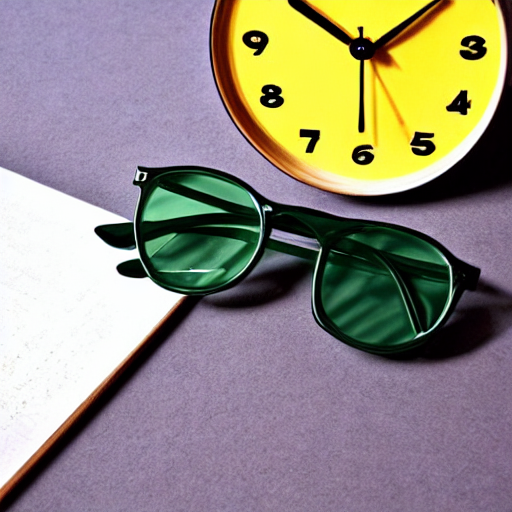

In [8]:
images[0].show()

## SD Output

In [9]:
out = sd_pipeline(
    prompt=prompt,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    generator=torch.Generator("cuda").manual_seed(seed),   
)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 23.16it/s]


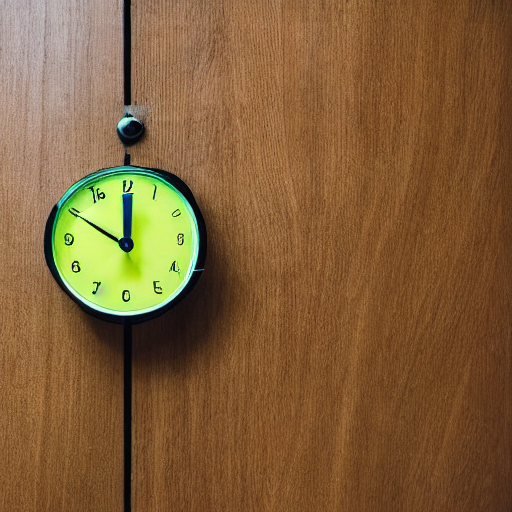

In [10]:
out.images[0].show()